In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import time



In [50]:
# Load the dataset
df = pd.read_csv('transaction_sample.csv')


# Calculate and display initial model performance
initial_auc = roc_auc_score(df['Is Fraudulent'], df['y_pred_proba'])
print(f"\nInitial model ROC-AUC: {initial_auc:.4f}")

# QUESTION 1: Determine which transactions need expert annotation
# Using uncertainty sampling - transactions where model prediction probability is close to decision threshold
uncertainty_threshold = 0.15  # Define range around decision threshold (0.5)
uncertain_indices = df[(df['y_pred_proba'] >= 0.5 - uncertainty_threshold) & 
                       (df['y_pred_proba'] <= 0.5 + uncertainty_threshold)].index

print(f"\nNumber of transactions requiring expert annotation: {len(uncertain_indices)}")
print(f"Percentage of total transactions: {len(uncertain_indices)/len(df)*100:.2f}%")

# Create a copy of the dataset to work with uncertain transactions
uncertain_df = df.loc[uncertain_indices].copy()


Initial model ROC-AUC: 0.7846

Number of transactions requiring expert annotation: 599
Percentage of total transactions: 12.67%


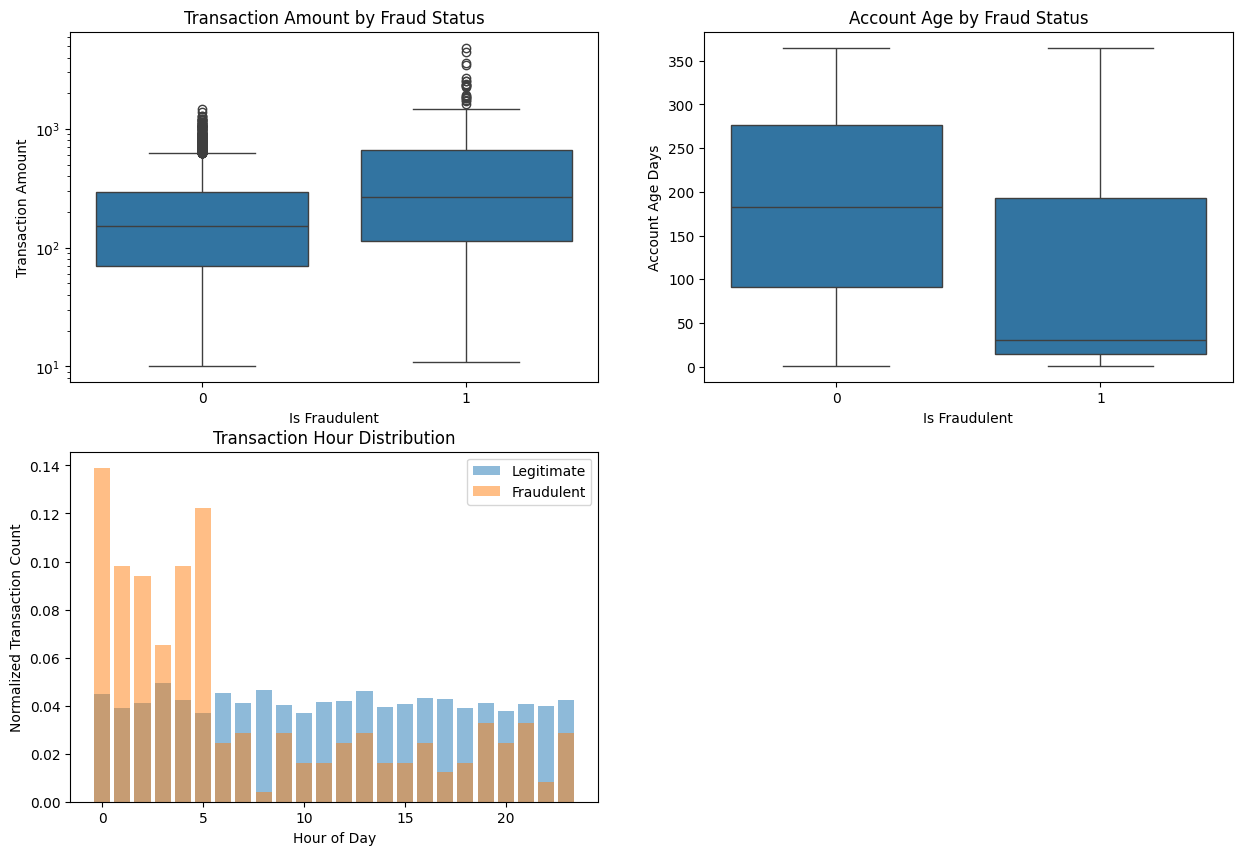

In [51]:
# QUESTION 2: Perform EDA to identify patterns and develop expert rules

# Analyze distributions between fraudulent and legitimate transactions
plt.figure(figsize=(15, 10))

# Transaction Amount by fraud status
plt.subplot(2, 2, 1)
sns.boxplot(x='Is Fraudulent', y='Transaction Amount', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.yscale('log')

# Account Age by fraud status
plt.subplot(2, 2, 2)
sns.boxplot(x='Is Fraudulent', y='Account Age Days', data=df)
plt.title('Account Age by Fraud Status')

# Transaction Hour by fraud status
plt.subplot(2, 2, 3)
fraud_hour = df[df['Is Fraudulent'] == 1]['Transaction Hour'].value_counts().sort_index()
non_fraud_hour = df[df['Is Fraudulent'] == 0]['Transaction Hour'].value_counts().sort_index()
fraud_hour_norm = fraud_hour / fraud_hour.sum()
non_fraud_hour_norm = non_fraud_hour / non_fraud_hour.sum()

hours = range(24)
plt.bar(hours, non_fraud_hour_norm, alpha=0.5, label='Legitimate')
plt.bar(hours, fraud_hour_norm, alpha=0.5, label='Fraudulent')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Transaction Count')
plt.title('Transaction Hour Distribution')
plt.legend()




**Transaction Amount by Fraud Status**

- Fraudulent transactions (labeled as "1") tend to have higher amounts compared to legitimate ones (labeled as "0")
- The median transaction amount for fraudulent transactions is approximately 3-4 times higher than legitimate transactions
- Fraudulent transactions show a wider range in the upper quartile, with some extreme high-value outliers
- This suggests that fraudsters target higher-value transactions, making amount a useful signal for fraud detection

**Account Age by Fraud Status**

- Fraudulent transactions are associated with significantly newer accounts
- Median account age for fraudulent transactions is around 30 days, compared to about 180 days for legitimate transactions
- The interquartile range for fraudulent transactions is smaller and concentrated in the lower range
- This strongly indicates that newer accounts pose higher fraud risk

**Transaction Hour Distribution**

- Fraudulent transactions show a clear time-of-day pattern
- Highest fraud rates occur during overnight hours (midnight to 5 AM)
- A second peak appears around 5-6 PM
- Legitimate transactions are more evenly distributed throughout the day
- The concentration of fraud during off-hours suggests timing is an important feature for detection

In [52]:
# Define expert rules based on EDA insights
def expert_annotation(row):
    """Expert rules based on observed patterns"""
    # Rule 1: High transaction amounts are more likely to be fraudulent
    if row['Transaction Amount'] > 1000:
        fraud_score = 0.7
    else:
        fraud_score = 0.3
    
    # Rule 2: New accounts (low account age) are more likely to be fraudulent
    if row['Account Age Days'] < 30:
        fraud_score += 0.2
    else:
        fraud_score -= 0.1
        
    # Rule 3: Transactions during unusual hours (early morning) are more suspicious
    if 0 <= row['Transaction Hour'] <= 5:
        fraud_score += 0.5
    else:
        fraud_score -= 0.1
    
    # Normalize score between 0 and 1
    fraud_score = max(0, min(1, fraud_score))
    
    # Convert to binary prediction
    return 1 if fraud_score > 0.5 else 0

# Apply expert annotation to uncertain transactions
start_time = time.time()

# Simulate expert review - measure time
uncertain_df['expert_annotation'] = uncertain_df.apply(expert_annotation, axis=1)
annotation_time = time.time() - start_time
time_per_transaction = annotation_time / len(uncertain_df)

print(f"Expert annotation time: {annotation_time:.4f} seconds")
print(f"Time per transaction: {time_per_transaction:.6f} seconds")

# Create new prediction column combining model prediction and expert annotations
df['y_pred_exp'] = df['y_pred'].copy()
df.loc[uncertain_indices, 'y_pred_exp'] = uncertain_df['expert_annotation']


Expert annotation time: 0.0046 seconds
Time per transaction: 0.000008 seconds


In [53]:
# QUESTION 3: Evaluate and compare performance

# Calculate ROC-AUC before and after HITL
auc_before = roc_auc_score(df['Is Fraudulent'], df['y_pred'])
auc_after = roc_auc_score(df['Is Fraudulent'], df['y_pred_exp'])

print(f"\nROC-AUC before HITL: {auc_before:.4f}")
print(f"ROC-AUC after HITL: {auc_after:.4f}")
print(f"Improvement: {(auc_after - auc_before) * 100:.2f}%")

# Calculate confusion matrices
conf_matrix_before = confusion_matrix(df['Is Fraudulent'], df['y_pred'])
conf_matrix_after = confusion_matrix(df['Is Fraudulent'], df['y_pred_exp'])

# Extract values from confusion matrices
tn_before, fp_before, fn_before, tp_before = conf_matrix_before.ravel()
tn_after, fp_after, fn_after, tp_after = conf_matrix_after.ravel()

# Calculate costs
# False Negative Cost: Transaction amount of fraudulent transactions incorrectly classified as legitimate
fn_cost_before = df[(df['Is Fraudulent'] == 1) & (df['y_pred'] == 0)]['Transaction Amount'].sum()
fn_cost_after = df[(df['Is Fraudulent'] == 1) & (df['y_pred_exp'] == 0)]['Transaction Amount'].sum()

# False Positive Cost: Transaction amount of legitimate transactions incorrectly classified as fraudulent
fp_cost_before = df[(df['Is Fraudulent'] == 0) & (df['y_pred'] == 1)]['Transaction Amount'].sum()
fp_cost_after = df[(df['Is Fraudulent'] == 0) & (df['y_pred_exp'] == 1)]['Transaction Amount'].sum()

# Time cost
ml_time_per_transaction = 0.00012  # seconds, as given
ml_total_time = ml_time_per_transaction * len(df)
hitl_total_time = ml_time_per_transaction * len(df) + time_per_transaction * len(uncertain_df)

cost_per_second = 0.01  # $0.01 per second as given
ml_time_cost = ml_total_time * cost_per_second
hitl_time_cost = hitl_total_time * cost_per_second

# Total costs
ml_total_cost = fn_cost_before + fp_cost_before + ml_time_cost
hitl_total_cost = fn_cost_after + fp_cost_after + hitl_time_cost

# Create summary table
summary = {
    'Model': ['Machine Learning (ML)', 'ML + HITL'],
    'ROC-AUC': [auc_before, auc_after],
    'FN Cost ($)': [fn_cost_before, fn_cost_after],
    'FP Cost ($)': [fp_cost_before, fp_cost_after],
    'Execution Time (s)': [ml_total_time, hitl_total_time],
    'Time Cost ($)': [ml_time_cost, hitl_time_cost],
    'Total Cost ($)': [ml_total_cost, hitl_total_cost]
}

summary_df = pd.DataFrame(summary)
print("\nPerformance and Cost Summary:")
print(summary_df.to_string(index=False))

# Calculate the percentage improvement or reduction in costs
fn_cost_change = (fn_cost_before - fn_cost_after) / fn_cost_before * 100 if fn_cost_before > 0 else 0
fp_cost_change = (fp_cost_before - fp_cost_after) / fp_cost_before * 100 if fp_cost_before > 0 else 0
total_cost_change = (ml_total_cost - hitl_total_cost) / ml_total_cost * 100

print(f"\nFalse Negative Cost Reduction: {fn_cost_change:.2f}%")
print(f"False Positive Cost Change: {fp_cost_change:.2f}%")
print(f"Total Cost Change: {total_cost_change:.2f}%")

# Assess if the HITL approach is justified
cost_justified = hitl_total_cost < ml_total_cost
print(f"\nIs HITL cost-justified? {'Yes' if cost_justified else 'No'}")

# Additional analysis of uncertain transactions
print("\nAnalysis of uncertain transactions:")
print(f"Total transactions: {len(df)}")
print(f"Uncertain transactions requiring expert review: {len(uncertain_df)}")
print(f"Percentage of uncertain transactions: {len(uncertain_df)/len(df)*100:.2f}%")

# Compare model predictions vs expert annotations on uncertain transactions
disagreement = uncertain_df[uncertain_df['y_pred'] != uncertain_df['expert_annotation']]
print(f"Cases where model and expert disagreed: {len(disagreement)}")
print(f"Disagreement rate within uncertain cases: {len(disagreement)/len(uncertain_df)*100:.2f}%")

# Check correctness of model vs expert on uncertain transactions
model_correct = uncertain_df[uncertain_df['y_pred'] == uncertain_df['Is Fraudulent']]
expert_correct = uncertain_df[uncertain_df['expert_annotation'] == uncertain_df['Is Fraudulent']]
print(f"Model accuracy on uncertain transactions: {len(model_correct)/len(uncertain_df)*100:.2f}%")
print(f"Expert accuracy on uncertain transactions: {len(expert_correct)/len(uncertain_df)*100:.2f}%")


ROC-AUC before HITL: 0.5921
ROC-AUC after HITL: 0.7829
Improvement: 19.08%

Performance and Cost Summary:
                Model  ROC-AUC  FN Cost ($)  FP Cost ($)  Execution Time (s)  Time Cost ($)  Total Cost ($)
Machine Learning (ML) 0.592125     66660.13     11939.79            0.567240       0.005672    78599.925672
            ML + HITL 0.782899     34349.32     32194.01            0.571815       0.005718    66543.335718

False Negative Cost Reduction: 48.47%
False Positive Cost Change: -169.64%
Total Cost Change: 15.34%

Is HITL cost-justified? Yes

Analysis of uncertain transactions:
Total transactions: 4727
Uncertain transactions requiring expert review: 599
Percentage of uncertain transactions: 12.67%
Cases where model and expert disagreed: 216
Disagreement rate within uncertain cases: 36.06%
Model accuracy on uncertain transactions: 79.63%
Expert accuracy on uncertain transactions: 79.30%


### Social Network Analysis

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('bank_data.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData summary:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())
print("\nFraud distribution:")
print(df['fraud'].value_counts())
print(f"Fraud rate: {df['fraud'].mean()*100:.2f}%")

# Question 1: Type of Fraud in Network


# Find customers and merchants whose transactions are all fraudulent
# For customers
customer_stats = df.groupby('customer').agg({'fraud': ['count', 'sum']})
customer_stats.columns = ['total_transactions', 'fraud_transactions']
fully_fraudulent_customers = customer_stats[customer_stats['total_transactions'] == 
                                           customer_stats['fraud_transactions']].index.tolist()

# For merchants
merchant_stats = df.groupby('merchant').agg({'fraud': ['count', 'sum']})
merchant_stats.columns = ['total_transactions', 'fraud_transactions']
fully_fraudulent_merchants = merchant_stats[merchant_stats['total_transactions'] == 
                                          merchant_stats['fraud_transactions']].index.tolist()


Dataset shape: (19966, 8)

First few rows:
   step     customer  age gender     merchant           category  amount  \
0    86  C1372889664    5      F  M1823072687  es_transportation    3.13   
1    26   C377075708    2      M   M348934600  es_transportation   27.11   
2    39  C1871594117    1      M  M1823072687  es_transportation   27.32   
3   176   C730142143    4      F   M348934600  es_transportation   37.87   
4   155  C1385354747    4      M  M1823072687  es_transportation   32.33   

   fraud  
0      0  
1      0  
2      0  
3      0  
4      0  

Data summary:
               step           age        amount         fraud
count  19966.000000  19966.000000  19966.000000  19966.000000
mean      95.157768      3.002104     37.493578      0.012121
std       50.994997      1.323806     98.785312      0.109427
min        0.000000      0.000000      0.000000      0.000000
25%       52.000000      2.000000     13.580000      0.000000
50%       97.000000      3.000000     27.030000

In [55]:
customer_stats.sort_values(by="fraud_transactions",ascending=False).head(3)

,total_transactions,fraud_transactions
customer,,
C1350963410,9,8
C1275518867,11,6
C245117318,7,6


In [56]:
merchant_stats.sort_values(by="fraud_transactions",ascending=False).head(3)

,total_transactions,fraud_transactions
merchant,,
M480139044,115,49
M980657600,57,48
M732195782,20,20


In [ ]:
print(f"\nNumber of customers with all fraudulent transactions: {len(fully_fraudulent_customers)}")
print(f"Number of merchants with all fraudulent transactions: {len(fully_fraudulent_merchants)}")

print("\nSample of fully fraudulent customers:")
print(fully_fraudulent_customers[:10])
print("\nSample of fully fraudulent merchants:")
print(fully_fraudulent_merchants[:5])


Number of customers with all fraudulent transactions: 34
Number of merchants with all fraudulent transactions: 5

Sample of fully fraudulent customers:
['C1233811793', 'C1289997724', 'C1338125837', 'C1501096176', 'C150891114', 'C1560904250', 'C1562081159', 'C1572610482', 'C1685492470', 'C1728122351']

Sample of fully fraudulent merchants:
['M1294758098', 'M1353266412', 'M1873032707', 'M3697346', 'M732195782']


Banking transaction networks can reveal several types of fraud patterns:

- **Organized Fraud Rings**: Groups of fraudsters working together, visible as clusters of connected customers and merchants with high fraud rates.
- **Money Laundering**: Complex transaction chains between multiple entities to obscure the source of funds.
- **First-Party Fraud**: Customers opening accounts with no intention to repay, showing specific transaction patterns before abandoning accounts.
- **Merchant Collusion**: Merchants that process fraudulent transactions, visible as nodes with high connections to fraudulent customers.

In [58]:
# Question 2: Network-Based Features

# Calculate degree centrality for customers and merchants
customer_degree = df.groupby('customer')['merchant'].nunique()
merchant_degree = df.groupby('merchant')['customer'].nunique()

# Map degree centrality back to each transaction
df['customer_degree_centrality'] = df['customer'].map(customer_degree)
df['merchant_degree_centrality'] = df['merchant'].map(merchant_degree)

# Calculate fraud proximity score for customers
customer_total_txns = df.groupby('customer')['fraud'].count()
customer_fraud_txns = df.groupby('customer')['fraud'].sum()
customer_fraud_proximity = customer_fraud_txns / customer_total_txns

# Calculate fraud proximity score for merchants
merchant_total_txns = df.groupby('merchant')['fraud'].count()
merchant_fraud_txns = df.groupby('merchant')['fraud'].sum()
merchant_fraud_proximity = merchant_fraud_txns / merchant_total_txns

# Map fraud proximity scores back to each transaction
df['customer_fraud_proximity'] = df['customer'].map(customer_fraud_proximity)
df['merchant_fraud_proximity'] = df['merchant'].map(merchant_fraud_proximity)

# Calculate average transaction value for customers and merchants
customer_avg_amount = df.groupby('customer')['amount'].mean()
merchant_avg_amount = df.groupby('merchant')['amount'].mean()

# Map average transaction values back to each transaction
df['customer_avg_amount'] = df['customer'].map(customer_avg_amount)
df['merchant_avg_amount'] = df['merchant'].map(merchant_avg_amount)

# Display sample of transactions with network features
print("\nSample transactions with network features:")
sample_cols = ['customer', 'merchant', 'amount', 'fraud', 
               'customer_degree_centrality', 'merchant_degree_centrality',
               'customer_fraud_proximity', 'merchant_fraud_proximity',
               'customer_avg_amount', 'merchant_avg_amount']
print(df[sample_cols].head())


Sample transactions with network features:
      customer     merchant  amount  fraud  customer_degree_centrality  \
0  C1372889664  M1823072687    3.13      0                           2   
1   C377075708   M348934600   27.11      0                           3   
2  C1871594117  M1823072687   27.32      0                           2   
3   C730142143   M348934600   37.87      0                           2   
4  C1385354747  M1823072687   32.33      0                           2   

   merchant_degree_centrality  customer_fraud_proximity  \
0                        3081                       0.0   
1                        2747                       0.0   
2                        3081                       0.0   
3                        2747                       0.0   
4                        3081                       0.0   

   merchant_fraud_proximity  customer_avg_amount  merchant_avg_amount  
0                       0.0            11.713333            27.124874  
1           

In [59]:
# Question 3: Build Model
# Prepare features for modeling

# One-hot encode categorical features
cat_features = ['age', 'gender', 'category']

# Create dummy variables
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Define traditional and network features
traditional_features = [col for col in df_encoded.columns if col not in 
                       ['step', 'customer', 'merchant', 'fraud'] and 
                       not col.startswith(('customer_', 'merchant_'))]

network_features = ['customer_degree_centrality', 'merchant_degree_centrality',
                   'customer_fraud_proximity', 'merchant_fraud_proximity',
                   'customer_avg_amount', 'merchant_avg_amount']

all_features = traditional_features + network_features

# Split the dataset
X = df_encoded[all_features]
y = df_encoded['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models with hyperparameter tuning
# 1. Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

print("\nLogistic Regression Best Parameters:")
print(grid_lr.best_params_)
print(f"Best ROC-AUC: {grid_lr.best_score_:.4f}")

# 2. Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_dt.fit(X_train_scaled, y_train)

print("\nDecision Tree Best Parameters:")
print(grid_dt.best_params_)
print(f"Best ROC-AUC: {grid_dt.best_score_:.4f}")

# Choose the best model (higher ROC-AUC)
if grid_lr.best_score_ > grid_dt.best_score_:
    best_model = grid_lr.best_estimator_
    best_model_name = "Logistic Regression"
else:
    best_model = grid_dt.best_estimator_
    best_model_name = "Decision Tree"

print(f"\nBest model: {best_model_name}")

# Evaluate on test set (with all features)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_all_features = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC with all features: {roc_auc_all_features:.4f}")




Logistic Regression Best Parameters:
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC-AUC: 0.9996

Decision Tree Best Parameters:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best ROC-AUC: 0.9759

Best model: Logistic Regression
Test ROC-AUC with all features: 0.9995


Test ROC-AUC with traditional features only: 0.9899

Performance Comparison:
             Feature Set   ROC AUC
0            Traditional  0.989850
1  Traditional + Network  0.999523

Performance improvement with network features: 0.98%

Conclusion:
Network-based features improved fraud detection performance by 0.98%.
The social network structure of transactions provides valuable additional signals for fraud detection.


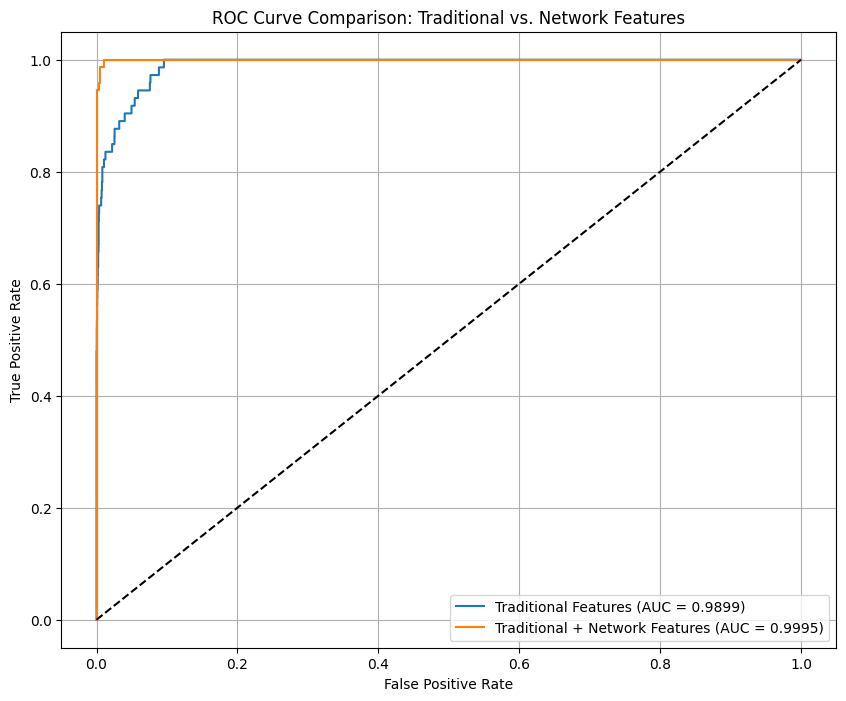

In [60]:
# Question 4: Evaluation Comparison
# Train the best model using only traditional features

# Scale traditional features only
X_train_trad = X_train[traditional_features]
X_test_trad = X_test[traditional_features]
X_train_trad_scaled = scaler.fit_transform(X_train_trad)
X_test_trad_scaled = scaler.transform(X_test_trad)

# Initialize the best model with the optimal hyperparameters
if best_model_name == "Logistic Regression":
    traditional_model = LogisticRegression(**grid_lr.best_params_, max_iter=1000)
else:
    traditional_model = DecisionTreeClassifier(**grid_dt.best_params_)

# Train on traditional features only
traditional_model.fit(X_train_trad_scaled, y_train)

# Evaluate on test set
y_pred_proba_trad = traditional_model.predict_proba(X_test_trad_scaled)[:, 1]
roc_auc_trad_features = roc_auc_score(y_test, y_pred_proba_trad)
print(f"Test ROC-AUC with traditional features only: {roc_auc_trad_features:.4f}")

# Comparison table
comparison_table = pd.DataFrame({
    'Feature Set': ['Traditional', 'Traditional + Network'],
    'ROC AUC': [roc_auc_trad_features, roc_auc_all_features]
})

print("\nPerformance Comparison:")
print(comparison_table)

# Compute improvement percentage
improvement = (roc_auc_all_features - roc_auc_trad_features) / roc_auc_trad_features * 100
print(f"\nPerformance improvement with network features: {improvement:.2f}%")

# Plot ROC curves for comparison
plt.figure(figsize=(10, 8))
# ROC for traditional features
fpr_trad, tpr_trad, _ = roc_curve(y_test, y_pred_proba_trad)
plt.plot(fpr_trad, tpr_trad, label=f'Traditional Features (AUC = {roc_auc_trad_features:.4f})')

# ROC for all features
fpr_all, tpr_all, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_all, tpr_all, label=f'Traditional + Network Features (AUC = {roc_auc_all_features:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Traditional vs. Network Features')
plt.legend()
plt.grid(True)

# Conclusion
print("\nConclusion:")
if roc_auc_all_features > roc_auc_trad_features:
    print(f"Network-based features improved fraud detection performance by {improvement:.2f}%.")
    print("The social network structure of transactions provides valuable additional signals for fraud detection.")
else:
    print("Network-based features did not significantly improve fraud detection performance.")
    print("Traditional transaction features may already capture most of the relevant fraud patterns.")